In [44]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.functional import F

from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import KFold

from data_loader import load_data, get_balanced_data, normalize_features

# import wandb
# wandb.init(project='gene')

data = load_data(ct='CA1-ProS_Glut')
X_balanced, y_balanced = get_balanced_data(data)
FEATURE_TYPES = ['dmr', 'atac', 'hic_loop', 'mcg_genebody']
for k, v in X_balanced.items():
    print(k, len(v))
# y_balanced = y_balanced[:, 2]
# print('zero:', (y_balanced == 0).sum(), 'non-zero:', (y_balanced != 0).sum())

Processed dmr data
Processed mCG genebody data
Processed mCH genebody data
Processed atac data
Processed hic loop data
Processed hic_abc_dmr data
Processed hic_abc_peak data
zero: 6930, non-zero: 1219
dmr 1828
mcg_genebody 1828
mch_genebody 1828
atac 1828
hic_loop 1828
hic_abc_dmr 1828
hic_abc_peak 1828


In [46]:
# check how many  0 , -1 and 1 in y_balanced
print('y_balanced 0:', np.sum(y_balanced == 0))
print('y_balanced -1:', np.sum(y_balanced == -1))
print('y_balanced 1:', np.sum(y_balanced == 1))


y_balanced 0: 609
y_balanced -1: 467
y_balanced 1: 752


In [47]:
import os
# 63%
HIDDEN_DIM = 64
NUM_LAYERS = 2
NUM_HEADS = 4
DROPOUT = 0.1
LR = 3e-3
OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
NUM_EPOCHS = 20
BATCH_SIZE = 32

# HIDDEN_DIM = 64
# NUM_LAYERS = 4
# NUM_HEADS = 8
# DROPOUT = 0.0
# LR = 0.03
# OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
# NUM_EPOCHS = 20
# BATCH_SIZE = 32

# HIDDEN_DIM = 64
# NUM_LAYERS = 1
# NUM_HEADS = 1
# DROPOUT = 0.3
# LR = 1e-4
# OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
# NUM_EPOCHS = 200
# BATCH_SIZE = 16


class FourHeadTransformerModel(nn.Module):
    def __init__(self, dmr_input_dim, atac_input_dim, hic_input_dim, genebody_input_dim, hidden_dim, output_dim, num_layers=2, num_heads=1, dropout=0.1):
        super(FourHeadTransformerModel, self).__init__()
        self.dmr_cls_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.atac_cls_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.hic_cls_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.genebody_cls_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.combined_cls_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.dmr_embedding = nn.Linear(dmr_input_dim, hidden_dim)
        self.atac_embedding = nn.Linear(atac_input_dim, hidden_dim)
        self.hic_embedding = nn.Linear(hic_input_dim, hidden_dim)
        self.genebody_embedding = nn.Linear(genebody_input_dim, hidden_dim)

        # TODO: may need to use tanh in attention instead of softmax
        encoder_layers = nn.TransformerEncoderLayer(hidden_dim, num_heads, dim_feedforward=hidden_dim*4, dropout=dropout, batch_first=True, norm_first=True)
        self.dmr_transformer = nn.TransformerEncoder(encoder_layers, num_layers)
        self.atac_transformer = nn.TransformerEncoder(encoder_layers, num_layers)
        self.hic_transformer = nn.TransformerEncoder(encoder_layers, num_layers)
        self.genebody_transformer = nn.TransformerEncoder(encoder_layers, num_layers)

        self.dmr_batch_norm = nn.BatchNorm1d(hidden_dim)
        self.atac_batch_norm = nn.BatchNorm1d(hidden_dim)
        self.hic_batch_norm = nn.BatchNorm1d(hidden_dim)
        self.genebody_batch_norm = nn.BatchNorm1d(hidden_dim)
        
        # Use self-attention mechanism to combine the outputs of the four heads
        self.query = nn.Parameter(torch.randn(1, hidden_dim))
        self.key_layer = nn.Linear(hidden_dim, hidden_dim)
        self.value_layer = nn.Linear(hidden_dim, hidden_dim)
        self.linear = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout))
        self.classifier = nn.Linear(hidden_dim, output_dim)
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Parameter):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)


        

    def forward(self, dmr_x, dmr_mask, atac_x, atac_mask, hic_x, hic_mask, genebody_x, genebody_mask, get_attn_weights=False):
        dmr_x = self.dmr_embedding(dmr_x)
        atac_x = self.atac_embedding(atac_x)
        hic_x = self.hic_embedding(hic_x)
        genebody_x = self.genebody_embedding(genebody_x)
        # Add cls embedding, so that we can take the first output as the representation of the sequence
        dmr_cls_embedding = self.dmr_cls_embedding.repeat(dmr_x.size(0), 1, 1)
        atac_cls_embedding = self.atac_cls_embedding.repeat(atac_x.size(0), 1, 1)
        hic_cls_embedding = self.hic_cls_embedding.repeat(hic_x.size(0), 1, 1)
        genebody_cls_embedding = self.genebody_cls_embedding.repeat(genebody_x.size(0), 1, 1)

        dmr_x = torch.cat((dmr_cls_embedding, dmr_x), dim=1)
        atac_x = torch.cat((atac_cls_embedding, atac_x), dim=1)
        hic_x = torch.cat((hic_cls_embedding, hic_x), dim=1)
        genebody_x = torch.cat((genebody_cls_embedding, genebody_x), dim=1)

        dmr_mask = torch.cat((torch.ones(dmr_mask.size(0), 1), dmr_mask), dim=1)
        atac_mask = torch.cat((torch.ones(atac_mask.size(0), 1), atac_mask), dim=1)
        hic_mask = torch.cat((torch.ones(hic_mask.size(0), 1), hic_mask), dim=1)
        genebody_mask = torch.cat((torch.ones(genebody_mask.size(0), 1), genebody_mask), dim=1)

        dmr_x = self.dmr_transformer(dmr_x, src_key_padding_mask=~dmr_mask.bool())
        atac_x = self.atac_transformer(atac_x, src_key_padding_mask=~atac_mask.bool())
        hic_x = self.hic_transformer(hic_x, src_key_padding_mask=~hic_mask.bool())
        genebody_x = self.genebody_transformer(genebody_x, src_key_padding_mask=~genebody_mask.bool())

        
        # Pooling, we should not use average pooling since the sequence length is also important
        dmr_x = dmr_x[:, 0, :]
        atac_x = atac_x[:, 0, :]
        hic_x = hic_x[:, 0, :]
        genebody_x = genebody_x[:, 0, :]

        dmr_x = self.dmr_batch_norm(dmr_x)
        atac_x = self.atac_batch_norm(atac_x)
        hic_x = self.hic_batch_norm(hic_x)
        genebody_x = self.genebody_batch_norm(genebody_x)

        # Combine the output of four heads into a sequence
        combined_x = torch.stack((dmr_x, atac_x, hic_x, genebody_x), dim=1) # (batch_size, 4, hidden_dim)

        # self-attention
        keys = self.key_layer(combined_x) # [N, 4, d]
        values = self.value_layer(combined_x) # [N, 4, d]
        query = self.query.expand(combined_x.size(0), -1).unsqueeze(-1)  # [N, d, 1]
        attn_scores = torch.matmul(keys, query).squeeze(-1)  # [N, 4]
        attn_weights = F.softmax(attn_scores, dim=-1)  # [N, 4]

        combined_x = torch.sum(values * attn_weights.unsqueeze(-1), dim=1) # [N, d]

        
        
        output = self.linear(combined_x) + combined_x
        output = self.classifier(output)
        if get_attn_weights:
            return output, attn_weights
        else:
            return output

class CombinedGeneDataset(Dataset):
    def __init__(self, dmr_data, atac_data, hic_data, genebody_data, labels):
        self.dmr_data = dmr_data
        self.atac_data = atac_data
        self.hic_data = hic_data
        self.genebody_data = genebody_data
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        dmr_gene_data = torch.FloatTensor(self.dmr_data[idx])
        atac_gene_data = torch.FloatTensor(self.atac_data[idx])
        hic_gene_data = torch.FloatTensor(self.hic_data[idx])
        genebody_gene_data = torch.FloatTensor(self.genebody_data[idx])
        label = torch.LongTensor([self.labels[idx].item() + 1])  # Add 1 to shift labels to 0, 1, 2
        dmr_mask = torch.ones(len(dmr_gene_data))
        atac_mask = torch.ones(len(atac_gene_data))
        hic_mask = torch.ones(len(hic_gene_data))
        genebody_mask = torch.ones(len(genebody_gene_data))
        return dmr_gene_data, atac_gene_data, hic_gene_data, genebody_gene_data, label, dmr_mask, atac_mask, hic_mask, genebody_mask

def combined_collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    dmr_sequences, atac_sequences, hic_sequences, genebody_sequences, labels, dmr_masks, atac_masks, hic_masks, genebody_masks = zip(*batch)
    
    dmr_lengths = [len(seq) for seq in dmr_sequences]
    atac_lengths = [len(seq) for seq in atac_sequences]
    hic_lengths = [len(seq) for seq in hic_sequences]
    genebody_lengths = [len(seq) for seq in genebody_sequences]
    dmr_max_len = max(dmr_lengths)
    atac_max_len = max(atac_lengths)
    hic_max_len = max(hic_lengths)
    genebody_max_len = max(genebody_lengths)
    
    padded_dmr_seqs = torch.zeros(len(dmr_sequences), dmr_max_len, dmr_sequences[0].size(1))
    padded_atac_seqs = torch.zeros(len(atac_sequences), atac_max_len, atac_sequences[0].size(1))
    padded_hic_seqs = torch.zeros(len(hic_sequences), hic_max_len, hic_sequences[0].size(1))
    padded_genebody_seqs = torch.zeros(len(genebody_sequences), genebody_max_len, genebody_sequences[0].size(1))
    padded_dmr_masks = torch.zeros(len(dmr_sequences), dmr_max_len)
    padded_atac_masks = torch.zeros(len(atac_sequences), atac_max_len)
    padded_hic_masks = torch.zeros(len(hic_sequences), hic_max_len)
    padded_genebody_masks = torch.zeros(len(genebody_sequences), genebody_max_len)

    
    for i, (dmr_seq, atac_seq, hic_seq, genebody_seq, dmr_length, atac_length, hic_length, genebody_length) in enumerate(zip(dmr_sequences, atac_sequences, hic_sequences, genebody_sequences, dmr_lengths, atac_lengths, hic_lengths, genebody_lengths)):
        padded_dmr_seqs[i, :dmr_length] = dmr_seq
        padded_atac_seqs[i, :atac_length] = atac_seq
        padded_hic_seqs[i, :hic_length] = hic_seq
        padded_genebody_seqs[i, :genebody_length] = genebody_seq
        padded_dmr_masks[i, :dmr_length] = 1
        padded_atac_masks[i, :atac_length] = 1
        padded_hic_masks[i, :hic_length] = 1
        padded_genebody_masks[i, :genebody_length] = 1
    
    return padded_dmr_seqs, padded_atac_seqs, padded_hic_seqs, padded_genebody_seqs, torch.cat(labels), padded_dmr_masks, padded_atac_masks, padded_hic_masks, padded_genebody_masks

def train_combined_model(X_train_dmr, X_train_atac, X_train_hic, X_train_genebody, y_train, X_test_dmr, X_test_atac, X_test_hic, X_test_genebody, y_test, exp_name, fold_idx):
    #wandb.init(project='gene', group=exp_name, name=f'fold-{fold_idx}')
    dmr_input_dim = len(X_train_dmr[0][0])
    atac_input_dim = len(X_train_atac[0][0])
    hic_input_dim = len(X_train_hic[0][0])
    genebody_input_dim = len(X_train_genebody[0][0])
    
    train_dataset = CombinedGeneDataset(X_train_dmr, X_train_atac, X_train_hic, X_train_genebody, y_train)
    test_dataset = CombinedGeneDataset(X_test_dmr, X_test_atac, X_test_hic, X_test_genebody, y_test)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=combined_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=combined_collate_fn)

    model = FourHeadTransformerModel(dmr_input_dim, atac_input_dim, hic_input_dim, genebody_input_dim, HIDDEN_DIM, OUTPUT_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS, dropout=DROPOUT)

    from sklearn.utils.class_weight import compute_class_weight

    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weights = torch.FloatTensor(class_weights)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)
    # optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    # lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0.0001)
    # lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS)

    # Create the OneCycleLR scheduler
    # lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, total_steps=NUM_EPOCHS,
    #                           pct_start=0.8, anneal_strategy='cos',
    #                           cycle_momentum=False, div_factor=5.0,
    #                           final_div_factor=10.0)

    def evaluate(model):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for dmr_x, atac_x, hic_x, genebody_x, batch_y, dmr_mask, atac_mask, hic_mask, genebody_mask in test_loader:
                outputs = model(dmr_x, dmr_mask, atac_x, atac_mask, hic_x, hic_mask, genebody_x, genebody_mask)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y.squeeze()).sum().item()
        return correct / total
    
    print(f'Initial Test Accuracy: {evaluate(model):.4f}')

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0
        for dmr_x, atac_x, hic_x, genebody_x, batch_y, dmr_mask, atac_mask, hic_mask, genebody_mask in train_loader:
            optimizer.zero_grad()
            outputs = model(dmr_x, dmr_mask, atac_x, atac_mask, hic_x, hic_mask, genebody_x, genebody_mask)
            loss = criterion(outputs, batch_y.squeeze())
            loss.backward()
            optimizer.step()
            # lr_scheduler.step()
            total_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == batch_y.squeeze()).sum().item()
            train_total += batch_y.size(0)

        accuracy = evaluate(model)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_correct/train_total:.4f}, Test Accuracy: {accuracy:.4f}')

        os.makedirs(f'checkpoints/model_{fold_idx}', exist_ok=True)
        torch.save(model.state_dict(), f'checkpoints/model_{fold_idx}/{epoch}.pth')
        #wandb.log({'epoch': epoch, 'LR': optimizer.param_groups[0]['lr'], 'train_loss': total_loss/len(train_loader), 'train_accuracy': train_correct/train_total, 'test_accuracy': accuracy})

    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for dmr_x, atac_x, hic_x, genebody_x, batch_y, dmr_mask, atac_mask, hic_mask, genebody_mask in test_loader:
            outputs = model(dmr_x, dmr_mask, atac_x, atac_mask, hic_x, hic_mask, genebody_x, genebody_mask)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    final_accuracy = sum(np.array(all_predictions) == np.array(all_labels).squeeze()) / len(all_labels)
    print(f'Final Test Accuracy: {final_accuracy:.4f}')
    return final_accuracy, all_predictions, all_labels, model

In [48]:
import time
exp_name = f'four-head-{time.strftime("%Y%m%d-%H%M%S")}'

# wandb.config.update({
#     'hidden_dim': HIDDEN_DIM,
#     'num_layers': NUM_LAYERS,
#     'num_heads': NUM_HEADS,
#     'dropout': DROPOUT,
#     'lr': LR,
#     'output_dim': OUTPUT_DIM,
#     'num_epochs': NUM_EPOCHS
# })


kf = KFold(n_splits=5, shuffle=True, random_state=25)
accuracies = []
for i, (train_index, test_index) in enumerate(kf.split(X_balanced['dmr'])):
    X_train_dmr, X_test_dmr = [X_balanced['dmr'][i] for i in train_index], [X_balanced['dmr'][i] for i in test_index]
    X_train_atac, X_test_atac = [X_balanced['atac'][i] for i in train_index], [X_balanced['atac'][i] for i in test_index]
    X_train_hic, X_test_hic = [X_balanced['hic_loop'][i] for i in train_index], [X_balanced['hic_loop'][i] for i in test_index]
    X_train_genebody, X_test_genebody = [X_balanced['mcg_genebody'][i] for i in train_index], [X_balanced['mcg_genebody'][i] for i in test_index]
    y_train, y_test = [y_balanced[i] for i in train_index], [y_balanced[i] for i in test_index]

    
    X_train_dmr_normalized, X_test_dmr_normalized = normalize_features(X_train_dmr, X_test_dmr)
    X_train_atac_normalized, X_test_atac_normalized = normalize_features(X_train_atac, X_test_atac)
    X_train_hic_normalized, X_test_hic_normalized = normalize_features(X_train_hic, X_test_hic)
    X_train_genebody_normalized, X_test_genebody_normalized = normalize_features(X_train_genebody, X_test_genebody)
    
    acc, preds, labels, model = train_combined_model(X_train_dmr_normalized, X_train_atac_normalized, X_train_hic_normalized, X_train_genebody_normalized, y_train, 
                                           X_test_dmr_normalized, X_test_atac_normalized, X_test_hic_normalized, X_test_genebody_normalized, y_test, exp_name=exp_name, fold_idx=i)
    torch.save(model.state_dict(), f'checkpoints/model_{i}/model.pth')
    accuracies.append(acc)


    # acc, preds, labels, model = train_combined_model(X_train_dmr_normalized, X_train_atac_normalized, X_train_hic_normalized, X_train_genebody_normalized, y_train,
    #                                           X_test_dmr_normalized, X_test_atac_normalized, X_test_hic_normalized, X_test_genebody_normalized, y_test, exp_name=exp_name, fold_idx=i)
    break

# print(f'Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')

/opt/conda/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Initial Test Accuracy: 0.3306
Epoch [1/20], Train Loss: 1.4289, Train Accuracy: 0.3776, Test Accuracy: 0.3798
Epoch [2/20], Train Loss: 1.2513, Train Accuracy: 0.3741, Test Accuracy: 0.2486
Epoch [3/20], Train Loss: 1.2241, Train Accuracy: 0.3509, Test Accuracy: 0.3470
Epoch [4/20], Train Loss: 1.1705, Train Accuracy: 0.4097, Test Accuracy: 0.3989
Epoch [5/20], Train Loss: 1.1407, Train Accuracy: 0.4083, Test Accuracy: 0.4508
Epoch [6/20], Train Loss: 1.1294, Train Accuracy: 0.3960, Test Accuracy: 0.4317
Epoch [7/20], Train Loss: 1.0807, Train Accuracy: 0.4514, Test Accuracy: 0.4536
Epoch [8/20], Train Loss: 1.0788, Train Accuracy: 0.4391, Test Accuracy: 0.4399
Epoch [9/20], Train Loss: 1.0825, Train Accuracy: 0.4357, Test Accuracy: 0.4317
Epoch [10/20], Train Loss: 1.0729, Train Accuracy: 0.4412, Test Accuracy: 0.4945
Epoch [11/20], Train Loss: 1.0461, Train Accuracy: 0.4665, Test Accuracy: 0.4536
Epoch [12/20], Train Loss: 1.0388, Train Accuracy: 0.4815, Test Accuracy: 0.4836
Epoch [

/var/tmp/ipykernel_150999/1045224161.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'checkpoints/model_{i}/1.pth'))


(366, 4)
2    151
1    121
0     94
Name: count, dtype: int64
2    308
1     57
0      1
Name: count, dtype: int64


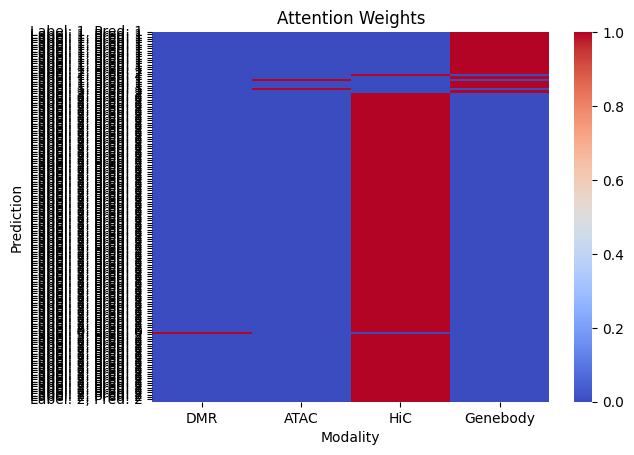

In [49]:
dmr_input_dim = len(X_test_dmr[0][0])
atac_input_dim = len(X_test_atac[0][0])
hic_input_dim = len(X_test_hic[0][0])
genebody_input_dim = len(X_test_genebody[0][0])
model = FourHeadTransformerModel(dmr_input_dim, atac_input_dim, hic_input_dim, genebody_input_dim, HIDDEN_DIM, OUTPUT_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS, dropout=DROPOUT)
model.load_state_dict(torch.load(f'checkpoints/model_{i}/1.pth'))
model.eval()

test_dataset = CombinedGeneDataset(X_test_dmr, X_test_atac, X_test_hic, X_test_genebody, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=combined_collate_fn)
all_preds = []
all_labels = []
attn_weights_list = []
with torch.no_grad():
    for dmr_x, atac_x, hic_x, genebody_x, batch_y, dmr_mask, atac_mask, hic_mask, genebody_mask in test_loader:
        outputs, attn_weights = model(dmr_x, dmr_mask, atac_x, atac_mask, hic_x, hic_mask, genebody_x, genebody_mask, get_attn_weights=True)
        pred = outputs.argmax(dim=1).cpu().numpy()
        attn_weights = attn_weights.cpu().numpy()
        all_preds.extend(pred)
        all_labels.extend(batch_y.cpu().numpy())
        attn_weights_list.append(attn_weights) # [N, 4]

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
attn_weights = np.concatenate(attn_weights_list, axis=0)
print(attn_weights.shape)

# Plot the attention weights (each attn_weight is a 4-dim vector)
# We should label each row with the pred and label, and each column with the
# modality name: dmr, atac, hic, genebody
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

# Find all the places where the prediction is correct
print(pd.Series(all_labels).value_counts())
print(pd.Series(all_preds).value_counts())

correct_idx = (all_preds == all_labels)
ax = sns.heatmap(attn_weights[correct_idx, :], annot=False, fmt='.2f', cmap='coolwarm')
ax.set_xlabel('Modality')
ax.set_xticklabels(['DMR', 'ATAC', 'HiC', 'Genebody'])
ax.set_ylabel('Prediction')
ax.set_yticks(range(sum(correct_idx)))
ax.set_yticklabels([f'Label: {i}, Pred: {j}' for i, j in zip(all_labels[correct_idx], all_preds[correct_idx])])
ax.set_title('Attention Weights')
plt.show()

In [50]:
for i, (acc, preds, labels, model) in enumerate(accuracies):
    print(f'Fold {i}: {acc:.4f}')

TypeError: cannot unpack non-iterable numpy.float64 object

# plot

In [6]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [9]:
_labels = [i[0] for i in labels]

result = pd.DataFrame([np.array(_labels) - 1, np.array(preds) - 1 ]).T
result.columns = ['true', 'pred']

<Axes: >

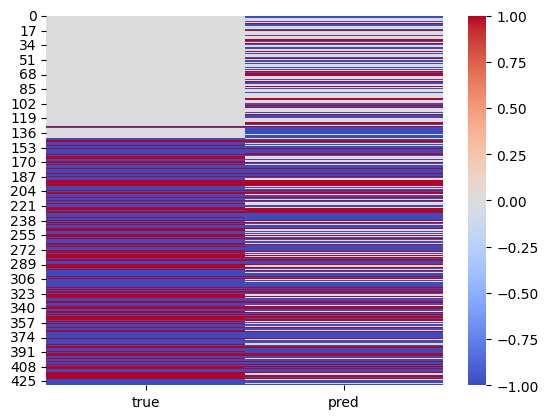

In [10]:
sns.heatmap(result, cmap = 'coolwarm')

In [11]:
result['predict_true'] = result['true'] == result['pred']

In [12]:

toplot= result.groupby('true')['predict_true'].mean()

In [13]:
toplot

true
-1    0.789157
 0    0.525180
 1    0.640000
Name: predict_true, dtype: float64

/var/tmp/ipykernel_44788/1903490480.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['down',  'non-age-deg', 'up',])


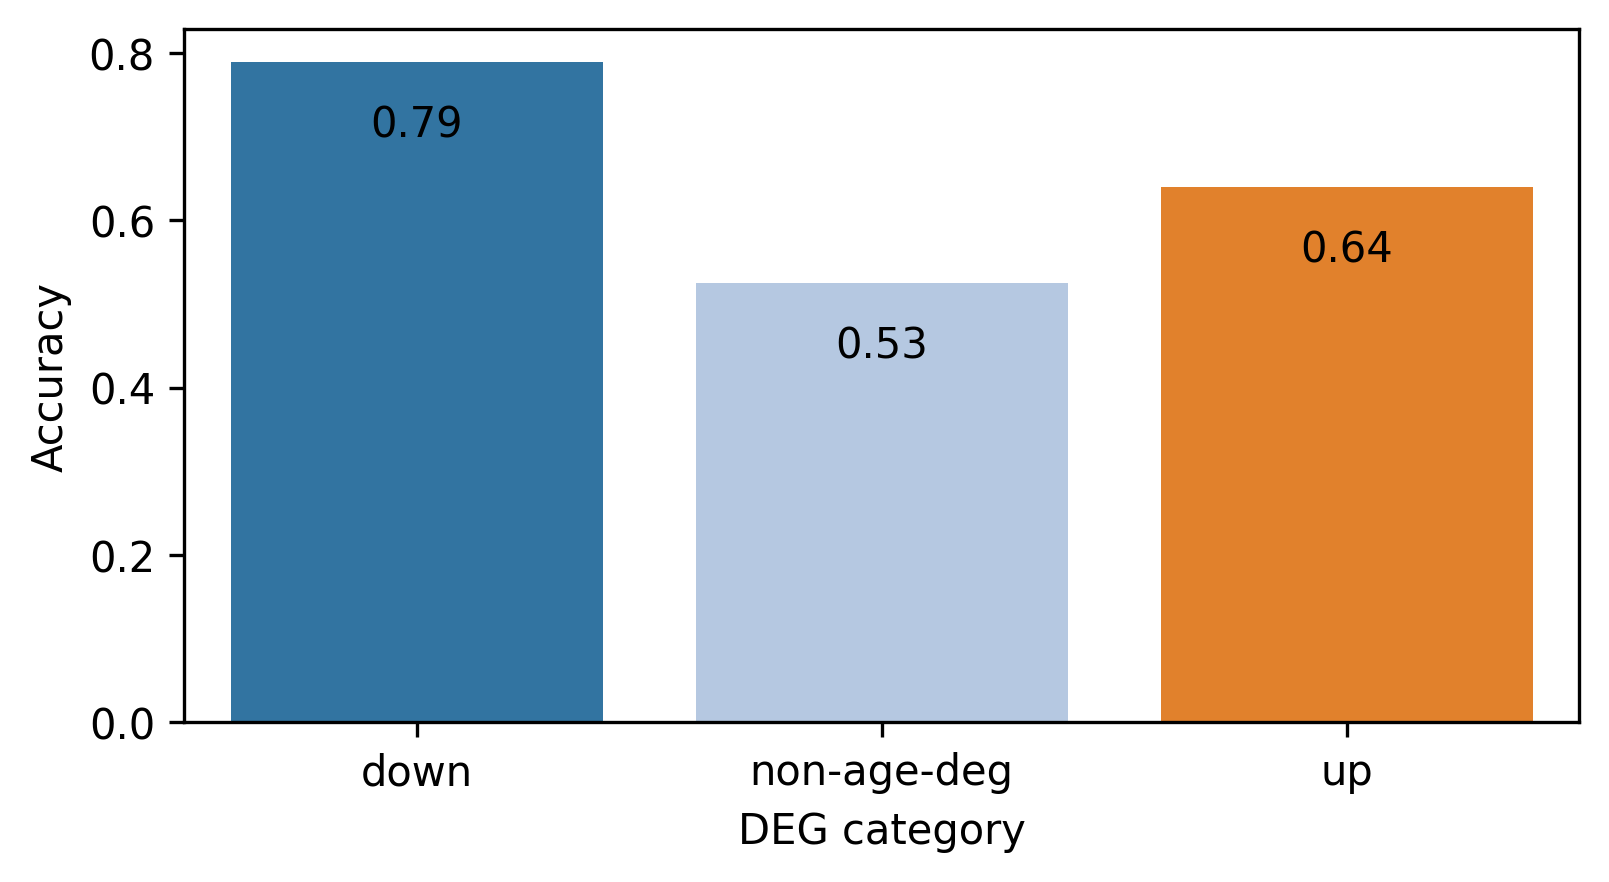

In [15]:
# make a barplot
fig, ax = plt.subplots(figsize=(6, 3), dpi = 300)
sns.barplot(x = toplot.index, ax = ax,palette='tab20',
            hue = toplot.index,y = toplot.values)
# change xticks label as down up and non-age-deg
ax.set_xticklabels(['down',  'non-age-deg', 'up',])
# set xlabel ad DEG category, y as accuracy
ax.set_xlabel('DEG category')
ax.set_ylabel('Accuracy')
#remove the egend
ax.get_legend().remove()
#label accuracy
for i in range(len(toplot)):
    ax.text(i, toplot.values[i]-0.1, round(toplot.values[i], 2), ha = 'center', va = 'bottom')